In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from glob import glob
import yaml
import numpy as np
from patoolib import extract_archive
import importlib

import utils             # the module to reload
importlib.reload(utils)  # reload the module
from utils import wkt2masc, load_images_from_folder

import cvae_model_v2             # the module to reload
importlib.reload(cvae_model_v2)  # reload the module
from cvae_model_v2 import CVAE

# warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
current_dir = os.getcwd()
BASE_DIR = os.path.dirname(current_dir)
dataset_dir = os.path.join(BASE_DIR, 'dataset')
data_dir = os.path.join(BASE_DIR, 'data')
config_file = os.path.join(BASE_DIR, 'config.yml')

DATA = "full"  # "full" or "sampled"

In [3]:
# if there isn´t unrar installed, install it with: sudo apt-get install unrar (linux)
# for windows, install it from: https://www.rarlab.com/rar_add.htm (unrarw32.exe)

dataset_path = os.path.join(dataset_dir, "BurnedAreaUAV_dataset")
if not os.path.exists(dataset_path):
    extract_archive(os.path.join(dataset_dir, "BurnedAreaUAV_dataset_v1.rar"), program="unrar", outdir=dataset_dir)
    os.remove(os.path.join(dataset_dir, "BurnedAreaUAV_dataset_v1.rar"))

with open(config_file, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

### Masks directories creation and conversion

In [4]:
dataset_train_msks_path = os.path.join(dataset_path, 'PNG', 'train', 'masks')
dataset_test_msks_path = os.path.join(dataset_path, 'PNG', 'test', 'masks')
train_msks_list = [os.path.basename(x) for x in glob(dataset_train_msks_path + "/*.png")]
test_msks_list = [os.path.basename(x) for x in glob(dataset_test_msks_path + "/*.png")]



# convert WKT files to segmentation masks : full train, sampled train and test
train_masks_dir = os.path.join(BASE_DIR, config["data"]["train_dir"], "masks")
if not os.path.exists(train_masks_dir):
    os.makedirs(train_masks_dir)

test_masks_dir = os.path.join(BASE_DIR, config["data"]["test_dir"], "masks")
if not os.path.exists(test_masks_dir):
    os.makedirs(test_masks_dir)

sampled_masks_txt_path = os.path.join(BASE_DIR, config["data"]["sampled_masks_txt"])
with open(sampled_masks_txt_path, "r", encoding="utf-8") as f:
    polygons = f.readlines()
    # extract indexes
    indexes = [int(polygon.split(",")[0]) for polygon in polygons]

train_sampled_masks_dir = os.path.join(BASE_DIR, config["data"]["train_sampled_dir"], "masks")
if not os.path.exists(train_sampled_masks_dir):
    os.makedirs(train_sampled_masks_dir)

wkt2masc(
    wkt_file=os.path.join(BASE_DIR, config["data"]["train_wkt"]),
    images_path=train_masks_dir,
    orig_dims=config["data"]["original_vid_dims"],
    height=config["data"]["input_size"][0],
    width=config["data"]["input_size"][1],
)

wkt2masc(
    wkt_file=os.path.join(BASE_DIR, config["data"]["test_wkt"]),
    images_path=test_masks_dir,
    orig_dims=config["data"]["original_vid_dims"],
    height=config["data"]["input_size"][0],
    width=config["data"]["input_size"][1],
)

wkt2masc(
    wkt_file=os.path.join(BASE_DIR, config["data"]["sampled_masks_wkt"]),
    images_path=train_sampled_masks_dir,
    orig_dims=config["data"]["original_vid_dims"],
    height=config["data"]["input_size"][0],
    width=config["data"]["input_size"][1],
)


    --------------------------------------
    # Properties of the resulting masks
    # Width: 512, Height: 512
    # Number of masks to create: 226
    --------------------------------------
    


100%|██████████| 226/226 [00:00<00:00, 555.39it/s]



    --------------------------------------
    # Properties of the resulting masks
    # Width: 512, Height: 512
    # Number of masks to create: 23
    --------------------------------------
    


100%|██████████| 23/23 [00:00<00:00, 560.96it/s]



    --------------------------------------
    # Properties of the resulting masks
    # Width: 512, Height: 512
    # Number of masks to create: 13
    --------------------------------------
    


100%|██████████| 13/13 [00:00<00:00, 571.05it/s]


In [5]:
# reconstruct the masks labels
msks_train_paths = sorted(glob(os.path.join(train_masks_dir, "*.png")))
msks_train_labels = [int(os.path.basename(m).split("_")[1].split(".")[0]) * 100 for m in msks_train_paths]
msks_test_paths = sorted(glob(os.path.join(test_masks_dir, "*.png")))
msks_test_labels = [int(os.path.basename(m).split("_")[1].split(".")[0]) * 100 + 20250 for m in msks_test_paths]
msks_train_sampled_paths = sorted(glob(os.path.join(train_sampled_masks_dir, "*.png")))
msks_train_sampled_labels = [100 * i for i in indexes]

print("Train masks:", len(msks_train_paths))
print("Train sampled masks:", len(msks_train_sampled_paths))
print("Test masks:", len(msks_test_paths))

Train masks: 226
Train sampled masks: 13
Test masks: 23


### Load masks and process labels

In [23]:
if DATA == 'full':
    TRAIN_DIR = os.path.join(BASE_DIR, config["data"]["train_dir"], "masks")
else:
    TRAIN_DIR = os.path.join(BASE_DIR, config["data"]["train_sampled_dir"], "masks")
TEST_DIR = os.path.join(BASE_DIR, config["data"]["test_dir"], "masks")

# train and test numpy arrays
train_masks = load_images_from_folder(TRAIN_DIR, target_size=config["data"]["input_size"][:2])
test_masks = load_images_from_folder(TEST_DIR, target_size=config["data"]["input_size"][:2])

# labels normalization and reshaping
max_val = np.max(msks_train_labels)
train_labels = (msks_train_labels/max_val).astype(np.float32)
train_labels = np.expand_dims(train_labels, axis=-1)
test_labels = (msks_test_labels/max_val).astype(np.float32)
test_labels = np.expand_dims(test_labels, axis=-1)

print("-" * 58)
print(f"{'Variable':<15} {'Shape':<18} {'Dtype':<8} {'Max':<8} {'Min':<8}")
print("-" * 58)
print(f"{'train_imgs':<15} {str(train_masks.shape):<18} {str(train_masks.dtype):<8}  {np.max(train_masks):.1f}   {np.min(train_masks):.1f}")
print(f"{'train_labels':<15} {str(train_labels.shape):<18} {str(train_labels.dtype):<8}  {np.max(train_labels):.1f}   {np.min(train_labels):.1f}")
print("~" * 58)
print(f"{'test_imgs':<15} {str(test_masks.shape):<18} {str(test_masks.dtype):<8}  {np.max(test_masks):.1f}   {np.min(test_masks):.1f}")
print(f"{'test_labels':<15} {str(test_labels.shape):<18} {str(test_labels.dtype):<8}  {np.max(test_labels):.1f}   {np.min(test_labels):.1f}")
print("-" * 58)

----------------------------------------------------------
Variable        Shape              Dtype    Max      Min     
----------------------------------------------------------
train_imgs      (226, 512, 512, 1) float32   1.0   -1.0
train_labels    (226, 1)           float32   1.0   0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
test_imgs       (23, 512, 512, 1)  float32   1.0   -1.0
test_labels     (23, 1)            float32   1.0   0.9
----------------------------------------------------------


### Models

In [10]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Activation, Dense, Lambda, Input, Dense
from tensorflow.keras.layers import MaxPooling2D, Flatten, Reshape, Concatenate
from tensorflow.keras.layers import SeparableConv2D, Conv2DTranspose
from tensorflow.keras import backend as K 
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [11]:
def deconv_block(input, filters, f_init="he_normal"):
   """
   Apply two convolutional layers with ReLU activation function.

   Args:
         input (tensor): Input tensor to the block.
         filters (int): Number of filters in the convolutional layers.
        
   Returns:
         tensor: Output tensor of the block with ReLU activation.
   """   
   x = Conv2DTranspose(filters, 
                     kernel_size = (4,4), 
                     strides=2,
                     kernel_initializer = f_init,
                     data_format = "channels_last", 
                     padding="same")(input)

   x = SeparableConv2D(filters, 
                     kernel_size = (4,4), 
                     depthwise_initializer = f_init,
                     pointwise_initializer = f_init,
                     padding="same")(x)
   x = Activation(tf.nn.leaky_relu)(x)

   x = SeparableConv2D(filters, 
                     kernel_size = (4,4), 
                     depthwise_initializer = f_init,
                     pointwise_initializer = f_init,
                     padding="same")(x)
   activation = Activation(tf.nn.leaky_relu)(x)
   
   return activation

In [12]:
def conv_block(input, filters, f_init="he_normal"):
    """
    Apply two convolutional layers with ReLU activation function.

    Args:
        input (tensor): Input tensor to the block.
        filters (int): Number of filters in the convolutional layers.

    Returns:
        tensor: Output tensor of the block with ReLU activation.
    """
    x = SeparableConv2D(filters, 
                        kernel_size = (4,4), 
                        depthwise_initializer = f_init,
                        pointwise_initializer = f_init,
                        padding="same")(input)
    x = Activation(tf.nn.leaky_relu)(x)

    x = SeparableConv2D(filters, 
                        kernel_size = (4,4), 
                        depthwise_initializer = f_init,
                        pointwise_initializer = f_init,
                        padding="same")(x)
    ativ = Activation(tf.nn.leaky_relu)(x)

    m_pool = MaxPooling2D(pool_size=(2, 2),
                          strides=2,
                          data_format="channels_last",
                          padding='same')(ativ)
    
    return m_pool

In [13]:
def sampler(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [18]:
H, W, C = config["data"]["input_size"]

#--------
# Encoder
#--------

encoder_inputs = Input(shape=(H, W, C))
# Reshape input to 2D image

x = conv_block(encoder_inputs, 
               config["CVAE"]["ref_filters"]*2, 
               config["CVAE"]["w_init"])
print(x.shape)
x = conv_block(x, 
               config["CVAE"]["ref_filters"]*1, 
               config["CVAE"]["w_init"])
print(x.shape)
x = Flatten()(x)
print(x.shape)
x = Dense(64, activation="leaky_relu")(x)

# VAE specific layers for mean and log variance
z_mean = Dense(config["CVAE"]["latent_dim"],  activation="relu", name="z_mean")(x)
z_log_var = Dense(config["CVAE"]["latent_dim"], activation="relu", name="z_log_var")(x)

# Sampling layer to sample z from the latent space
z = Lambda(sampler, output_shape=(config["CVAE"]["latent_dim"],), name='z')([z_mean, z_log_var])

# Instantiate encoder model
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

#--------
# Decoder
#--------

latent_inputs = Input(shape=(config["CVAE"]["latent_dim"],), name='z_sampling')
label_inputs = Input(shape=(len(train_labels[0]),), name='label')
decoder_inputs = Concatenate()([latent_inputs, label_inputs])
x = Dense(64*64*64, activation="relu")(decoder_inputs)
x = Reshape((128,128,16))(x)
x = deconv_block(x, config["CVAE"]["ref_filters"]*2, 
                 config["CVAE"]["w_init"])
x = deconv_block(x, config["CVAE"]["ref_filters"]*4, 
                 config["CVAE"]["w_init"])
decoder_output = Conv2DTranspose(1, 3, activation="tanh", padding="same")(x)

# decoder_output = Reshape(INPUT_SHAPE)(x)

decoder = Model([latent_inputs, label_inputs], decoder_output, name="decoder")

#-----------------
# Conditional VAE
#-----------------

outputs = decoder([encoder(encoder_inputs)[2], label_inputs])
cvae = Model([encoder_inputs, label_inputs], outputs, name='cvae')
cvae.summary()

(None, 256, 256, 64)
(None, 128, 128, 32)
(None, 524288)
Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 encoder (Functional)        [(None, 64),                 3357281   ['input_2[0][0]']             
                              (None, 64),                 6                                       
                              (None, 64)]                                                         
                                                                                                  
 label (InputLayer)          [(None, 1)]                  0         []                            
                                      

In [19]:
def mse_kl_loss(y_true, y_pred, beta: float = 1.0):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    squared_difference = tf.square(y_true - y_pred)
    recontruction = tf.reduce_mean(squared_difference, axis=-1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed from as both dist. are Gaussian
    kl_divergence = 0.5 * tf.reduce_sum(tf.exp(z_log_var) + tf.square(z_mean) - 1. - z_log_var, axis=-1)
    return recontruction + beta*kl_divergence

In [21]:
cvae.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 3e-4),
             loss=mse_kl_loss)

In [36]:
history = cvae.fit([train_masks, train_labels],
                     train_masks,
                     epochs=1000,
                     batch_size=1,
                     validation_data=([test_masks, test_labels], test_masks),
                     )

Train on 203 samples, validate on 23 samples
Epoch 1/1000
147/203 [====================>.........] - ETA: 9s - loss: 0.1290

KeyboardInterrupt: 

In [ ]:
import  visualization             # the module to reload
# reload the module
importlib.reload(visualization)
from visualization import plot_learning_curves

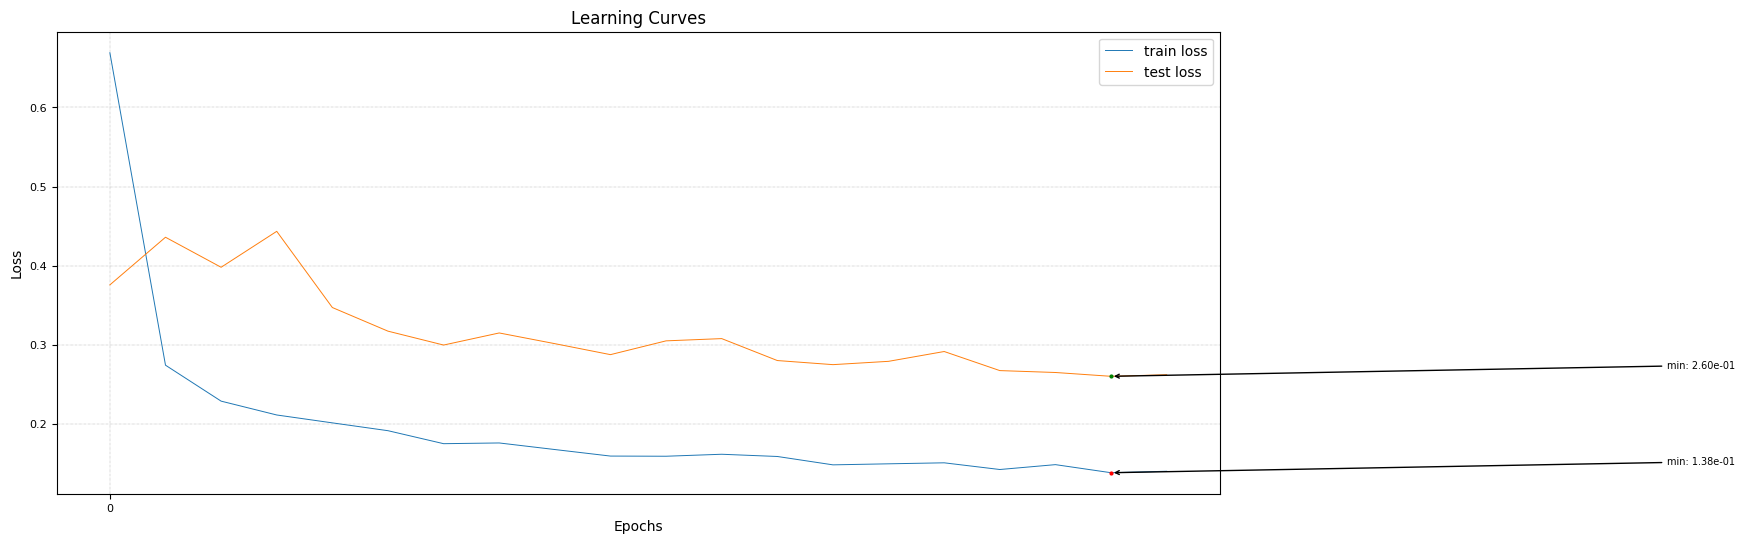

In [ ]:
# plot history
plt.rcParams.update({'figure.max_open_warning': 0})
plot_learning_curves(history,log_scale=False)